In [59]:
import sklearn as sk
import scipy as sp
import pandas as pd
import numpy as np  
import math
import random
import gym
import sys

from six import StringIO, b
from gym import utils
from gym.envs.toy_text import discrete
import time, pickle, os
import matplotlib.pyplot as plt

%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [262]:
#Construction of Frozen Lake Problem
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ]

}

class FrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, map_name, desc=None, is_slippery=True):
        if desc is None and map_name is None:
            raise ValueError('Must provide either desc or map_name')
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        P = {s : {a : [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row*ncol + col
        
        def inc(row, col, a):
            if a==0: # left
                col = max(col-1,0)
            elif a==1: # down
                row = min(row+1,nrow-1)
            elif a==2: # right
                col = min(col+1,ncol-1)
            elif a==3: # up
                row = max(row-1,0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'GH':
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a-1)%4, a, (a+1)%4]:
                                newrow, newcol = inc(row, col, b)
                                newstate = to_s(newrow, newcol)
                                newletter = desc[newrow, newcol]
                                done = bytes(newletter) in b'GH'
                                rew = float(newletter == b'G')
                                li.append((1.0/3.0, newstate, rew, done))
                        else:
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            done = bytes(newletter) in b'GH'
                            rew = float(newletter == b'G')
                            li.append((1.0, newstate, rew, done))

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            return outfile

In [205]:
"""
Solving FrozenLake environment using Value-Iteration.
"""
import numpy as np
import gym
from gym import wrappers


def run_episode(env, policy, gamma=1.0, render = False):
    """ Evaluates policy by using it to run an episode and finding its
    total reward.
    args:
    env: gym environment.
    policy: the policy to be used.
    gamma: discount factor.
    render: boolean to turn rendering on/off.
    returns:
    total reward: real value of the total reward recieved by agent under policy.
    """
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward


def evaluate_policy(env, policy, gamma = 1.0,  n = 100):
    """ Evaluates a policy by running it n times.
    returns:
    average total reward
    """
    scores = [
            run_episode(env, policy, gamma = gamma, render = False)
            for _ in range(n)]
    return np.mean(scores)

def extract_policy(env, v, gamma = 1.0):
    """ Extract the policy given a value-function """
    policy = np.zeros(env.nS)
    for s in range(env.nS):
        q_sa = np.zeros(env.action_space.n)
        for a in range(env.action_space.n):
            for next_sr in env.P[s][a]:
                # next_sr is a tuple of (probability, next state, reward, done)
                p, s_, r, _ = next_sr
                q_sa[a] += (p * (r + gamma * v[s_]))
        policy[s] = np.argmax(q_sa)
    return policy


def value_iteration(env, graphs, gamma=1.0):
    """ Value-iteration algorithm """
    difference_in_sum_of_values = []
    sum_of_values = []
    v = np.zeros(env.nS)  # initialize value-function. Is total number of states (squares in grid space)
    max_iterations = 100000
    eps = 1e-20
    times = []
    
    for i in range(max_iterations):
        start = time.time()
        prev_v = np.copy(v)
        for s in range(env.nS):
            q_sa = [sum([p*(r + prev_v[s_]) for p, s_, r, _ in env.P[s][a]]) for a in range(env.nA)] 
            v[s] = max(q_sa)
        difference_in_sum_of_values.append(np.sum(np.fabs(prev_v - v)))
        sum_of_values.append(np.sum(v))
        if (np.sum(np.fabs(prev_v - v)) <= eps):
            print ('Value-iteration converged at iteration %d.' %(i+1))
            break
        end = time.time()
        times.append(end - start)
    
    avg_time = []
    for i in range(len(times)):
        avg_time.append(np.mean(times[0:i]))
    
    if graphs:
        construct_plot(difference_in_sum_of_values, "Difference in Sum of Values Between Iterations", "Iteration", "Difference in Values")
        construct_plot(sum_of_values, "Sum of Values Per State", "Iteration", "Summed Value of Grid")
        construct_plot(times, "Time per Iteration", "Iteration", "Time")
        construct_plot(avg_time, "Average Time Per Iteration", "Iteration", "Time")
    return v

def construct_plot(values, plt_title, x_axis, y_axis):
    plt.figure(figsize=(9, 6))
    plt.plot(list(range(1, len(values) + 1)), values)
    plt.title(plt_title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.show()

In [206]:
def policy_iteration(env, graphs, gamma = 1.0):
    """ Policy-Iteration algorithm """
    policy = np.random.choice(env.nA, size=(env.nS))  # initialize a random policy
    max_iterations = 200000
    gamma = 1.0
    value_function_iterations = []
    v_s = []
    times = []
    reached_convergence = float("-inf")
    for i in range(max_iterations):
        start = time.time()
        old_policy_v, num_iter = compute_policy_v(env, policy, gamma)
        v_s.append(np.sum(old_policy_v))
        value_function_iterations.append(num_iter)
        new_policy = extract_policy(env, old_policy_v, gamma)
        if (np.all(policy == new_policy)):
            print ('Policy-Iteration converged at step %d.' %(i+1))
            reached_convergence = i+1
            break
        policy = new_policy
        end = time.time()
        times.append(end - start)
    
    avg_time = []
    for i in range(len(times)):
        avg_time.append(np.mean(times[0:i]))
    
    if graphs:
        construct_plot(value_function_iterations, "Iterations Per Value Function Convergence for Policy", "Num Policies", "Num Iterations")
        construct_plot(v_s, "Sum of Value for Policy", "Num Policies", "Value for Policy")
        construct_plot(times, "Time per Iteration", "Iteration", "Time")
        construct_plot(avg_time, "Average Time Per Iteration", "Iteration", "Time")
    return policy, reached_convergence

def compute_policy_v(env, policy, gamma=1.0):
    """ Iteratively evaluate the value-function under policy.
    Alternatively, we could formulate a set of linear equations in iterms of v[s] 
    and solve them to find the value function.
    """
    v = np.zeros(env.nS)
    eps = 1e-10
    num_iter = 0
    while True:
        prev_v = np.copy(v)
        for s in range(env.nS):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, _ in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            # value converged
            break
        num_iter += 1
    return v, num_iter

In [208]:
def run_value_iteration(problem_type, graphs=True, gamma=1.0, stochastic=True):
    env = FrozenLakeEnv(map_name=problem_type, is_slippery=stochastic)
    start = time.time()
    optimal_v = value_iteration(env, graphs, gamma)
    end = time.time()
    policy = extract_policy(env, optimal_v, gamma)
    policy_score = evaluate_policy(env, policy, gamma, n=1000)
    print('Policy average score = ', policy_score)
    print ('Total time for value iteration to converge = ', end - start)

def run_policy_iteration(problem_type, graphs=True, gamma=1.0, stochastic=True):
    env = FrozenLakeEnv(map_name=problem_type, is_slippery=stochastic)
    start = time.time()
    optimal_policy, convergence_steps = policy_iteration(env, graphs, gamma=1.0)
    end = time.time()
    scores = evaluate_policy(env, optimal_policy, gamma=1.0)
    print('Average scores = ', np.mean(scores))
    print ('Total time for policy iteration to converge = ', end - start)
    return convergence_steps

Value-iteration converged at iteration 1373.


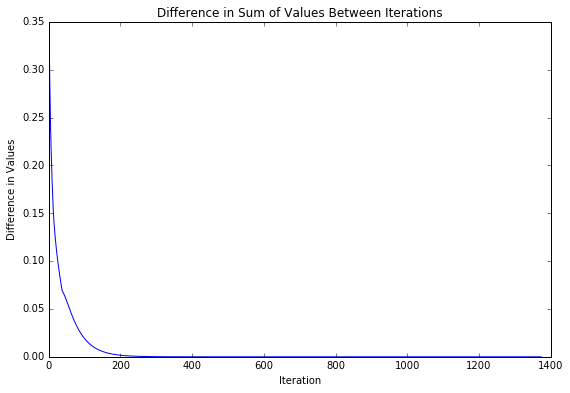

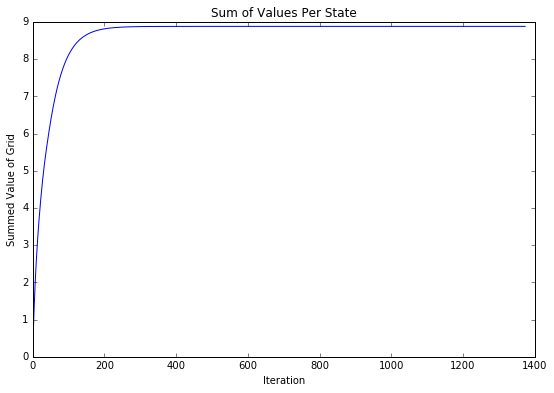

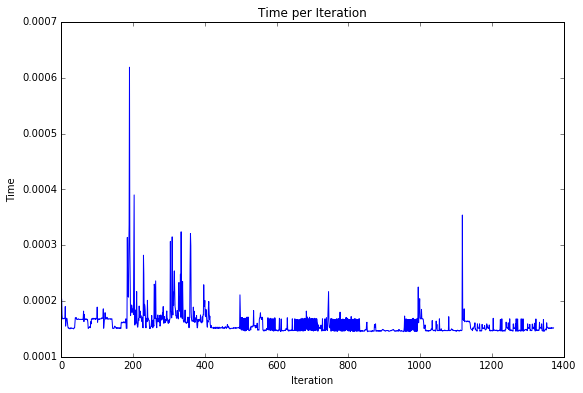

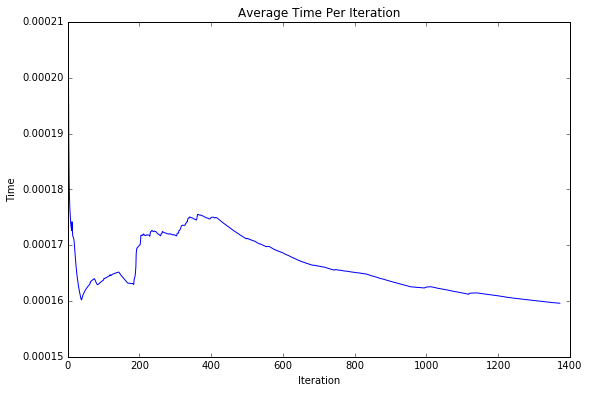

Policy average score =  0.814
Total time for value iteration to converge =  1.0513269901275635


In [209]:
run_value_iteration("4x4")

Value-iteration converged at iteration 2357.


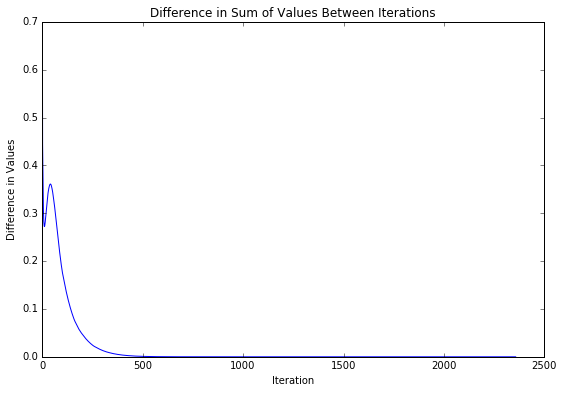

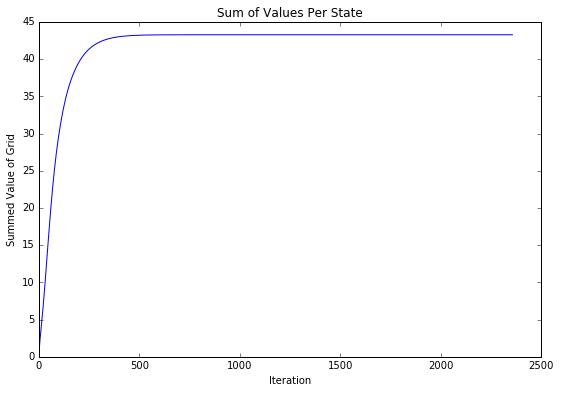

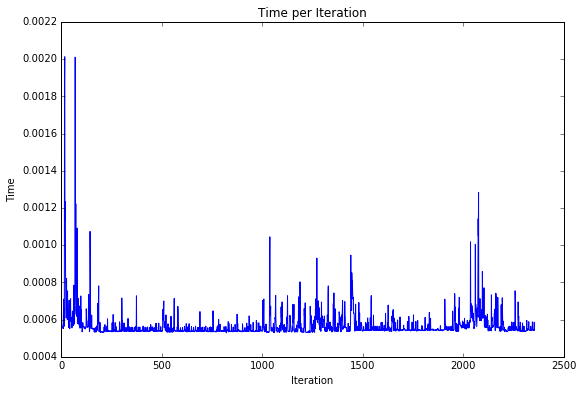

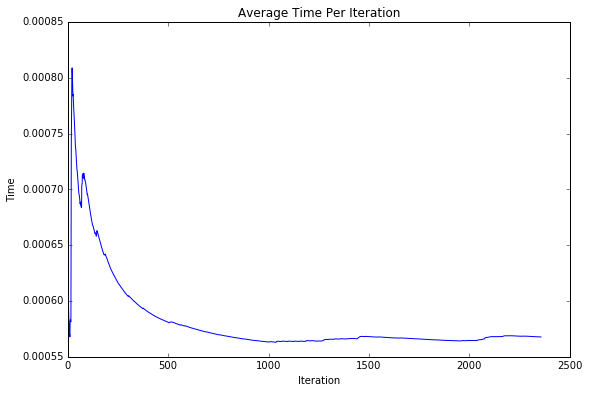

Policy average score =  1.0
Total time for value iteration to converge =  2.2674849033355713


In [210]:
run_value_iteration("8x8")

Policy-Iteration converged at step 5.


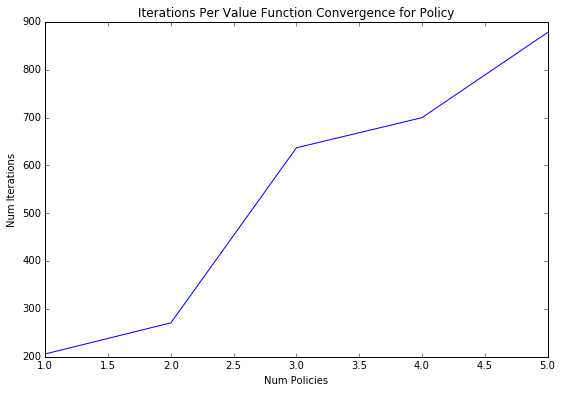

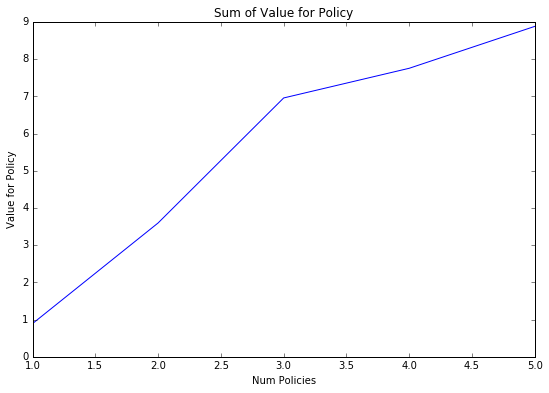

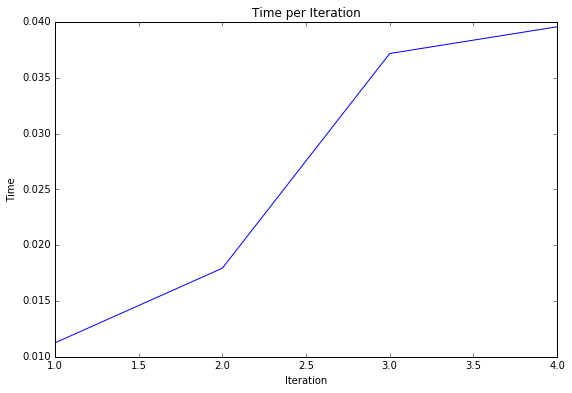

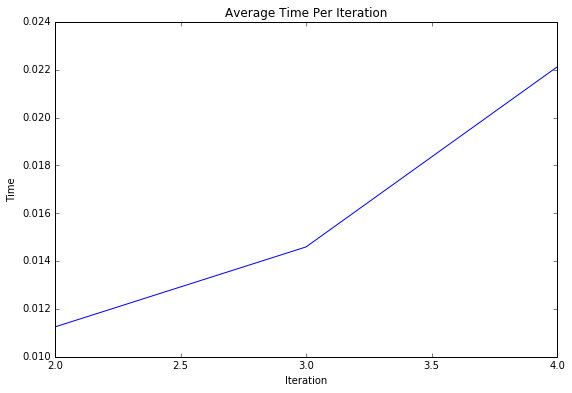

Average scores =  0.77
Total time for policy iteration to converge =  1.0376379489898682


5

In [211]:
run_policy_iteration("4x4")

Policy-Iteration converged at step 10.


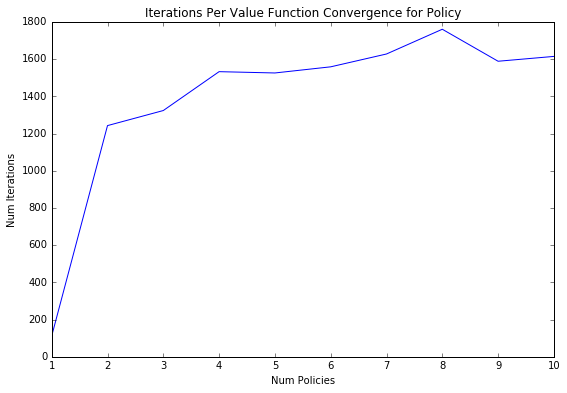

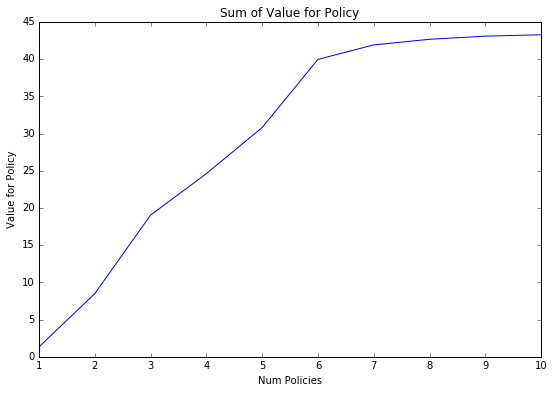

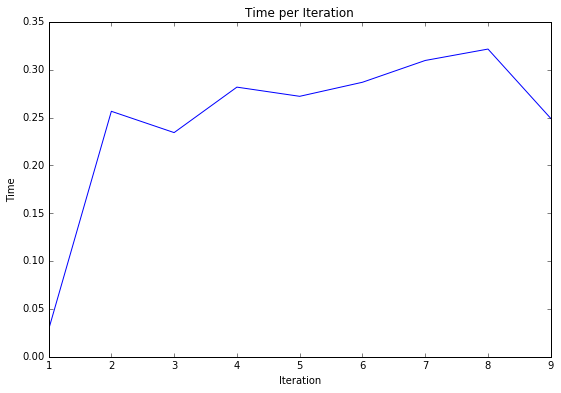

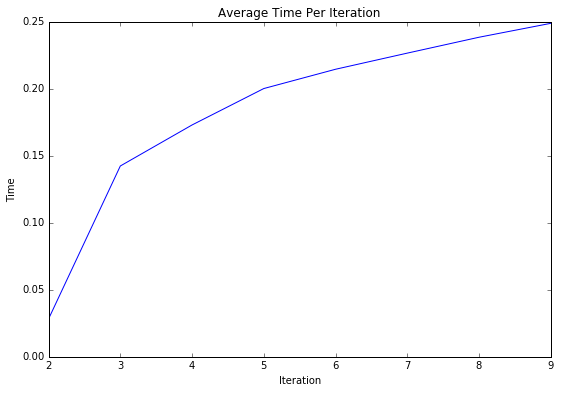

Average scores =  1.0
Total time for policy iteration to converge =  3.3271849155426025


10

In [212]:
run_policy_iteration("8x8")

Policy-Iteration converged at step 7.
Average scores =  0.8
Total time for policy iteration to converge =  0.15987396240234375
Policy-Iteration converged at step 5.
Average scores =  0.85
Total time for policy iteration to converge =  0.11977410316467285
Policy-Iteration converged at step 3.
Average scores =  0.83
Total time for policy iteration to converge =  0.09168601036071777
Policy-Iteration converged at step 4.
Average scores =  0.83
Total time for policy iteration to converge =  0.1326911449432373
Policy-Iteration converged at step 6.
Average scores =  0.81
Total time for policy iteration to converge =  0.13836097717285156
Policy-Iteration converged at step 2.
Average scores =  0.81
Total time for policy iteration to converge =  0.06144094467163086
Policy-Iteration converged at step 7.
Average scores =  0.78
Total time for policy iteration to converge =  0.14728808403015137
Policy-Iteration converged at step 4.
Average scores =  0.73
Total time for policy iteration to converge =

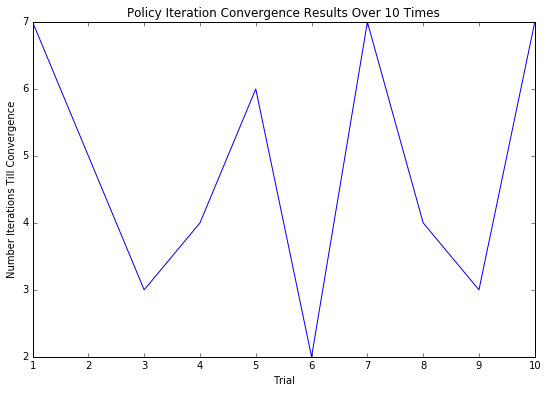

In [214]:
steps_till_convergence = []
for i in range(10):
    steps_till_convergence.append(run_policy_iteration("4x4", graphs=False))
construct_plot(steps_till_convergence, "Policy Iteration Convergence Results Over 10 Times", "Trial", "Number Iterations Till Convergence")

Policy-Iteration converged at step 12.
Average scores =  1.0
Total time for policy iteration to converge =  2.670212984085083
Policy-Iteration converged at step 12.
Average scores =  1.0
Total time for policy iteration to converge =  2.6544058322906494
Policy-Iteration converged at step 11.
Average scores =  1.0
Total time for policy iteration to converge =  2.4549219608306885
Policy-Iteration converged at step 12.
Average scores =  1.0
Total time for policy iteration to converge =  2.6505091190338135
Policy-Iteration converged at step 7.
Average scores =  1.0
Total time for policy iteration to converge =  1.8843700885772705
Policy-Iteration converged at step 7.
Average scores =  1.0
Total time for policy iteration to converge =  1.8446269035339355
Policy-Iteration converged at step 13.
Average scores =  1.0
Total time for policy iteration to converge =  3.053361177444458
Policy-Iteration converged at step 5.
Average scores =  1.0
Total time for policy iteration to converge =  1.262413

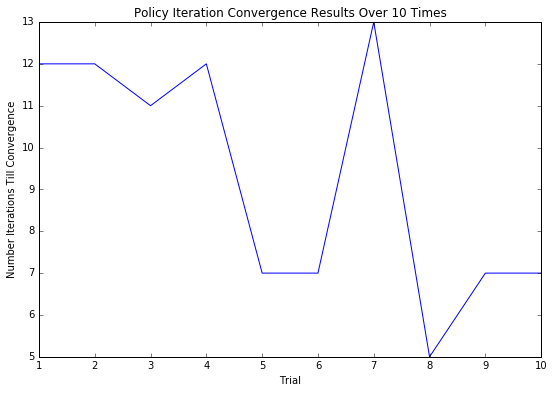

In [215]:
steps_till_convergence = []
for i in range(10):
    steps_till_convergence.append(run_policy_iteration("8x8", graphs=False))
construct_plot(steps_till_convergence, "Policy Iteration Convergence Results Over 10 Times", "Trial", "Number Iterations Till Convergence")

In [254]:
def run_Qlearning(problem_type, total_episodes=15000, learning_rate=0.8, max_steps=99, gamma=0.95, epsilon=1.0, 
                  max_epsilon=1.0, min_epsilon=0.01, decay_rate=0.005, stochastic=True):
    #Exploration parameters: Exploration rate, Exploration probability at start, 
    #Minimum exploration probability , Exponential decay rate for exploration prob
    
    env = FrozenLakeEnv(problem_type, is_slippery=stochastic)
    action_size = env.action_space.n
    state_size = env.observation_space.n
    qtable = np.zeros((state_size, action_size))

    # List of rewards
    rewards = []
    steps_per_iteration = []
    epsilons = []
    times = []

    # 2 For life or until learning is stopped
    total_start = time.time()
    for episode in range(total_episodes):
        # Reset the environment
        state = env.reset()
        step = 0
        done = False
        total_rewards = 0
        
        start = time.time()
        for step in range(max_steps):
            # 3. Choose an action a in the current world state (s)
            ## First we randomize a number
            exp_exp_tradeoff = random.uniform(0, 1)

            ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
            if exp_exp_tradeoff > epsilon:
                action = np.argmax(qtable[state,:])

            # Else doing a random choice --> exploration
            else:
                action = env.action_space.sample()

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done, info = env.step(action)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            # qtable[new_state,:] : all the actions we can take from new state
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])

            total_rewards += reward

            # Our new state is state
            state = new_state

            # If done (if we're dead) : finish episode
            if done == True: 
                steps_per_iteration.append(step)
                break
            
            if step == max_steps - 1:
                steps_per_iteration.append(step)
        end = time.time()
        times.append(end - start)

        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
        epsilons.append(epsilon)
        rewards.append(total_rewards)
    total_end = time.time()
    
    avg_reward_up_till_iteration = []
    for i in range(len(rewards)):
        avg_reward_up_till_iteration.append(np.mean(rewards[0:i]))
    construct_plot(avg_reward_up_till_iteration, "Average Reward Per Episode", "Episode", "Total Reward")
    
    avg_number_steps_up_till_iteration = []
    for i in range(len(steps_per_iteration)):
        avg_number_steps_up_till_iteration.append(np.mean(steps_per_iteration[0:i]))
    construct_plot(avg_number_steps_up_till_iteration, "Average Number of Steps Per Episode", "Episode", "Number Steps")
    
    construct_plot(epsilons, "Epsilon For Episode", "Episode", "Epsilon")
    construct_plot(times, "Time per Episode", "Episode", "Time")
    
    avg_time = []
    for i in range(len(times)):
        avg_time.append(np.mean(times[0:i]))
    construct_plot(avg_time, "Average Time Per Episode", "Episode", "Time")
    
#     print(qtable)
    print ("Score over time: " +  str(sum(rewards)/total_episodes))
    print ('Total time for Q-Learning = ', total_end - total_start)

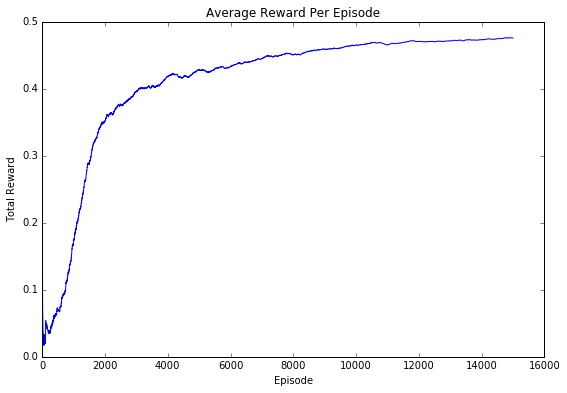

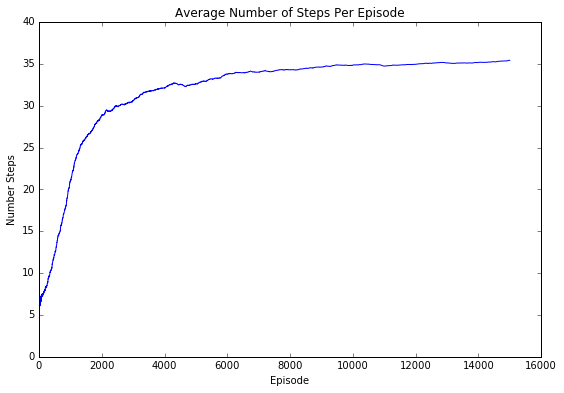

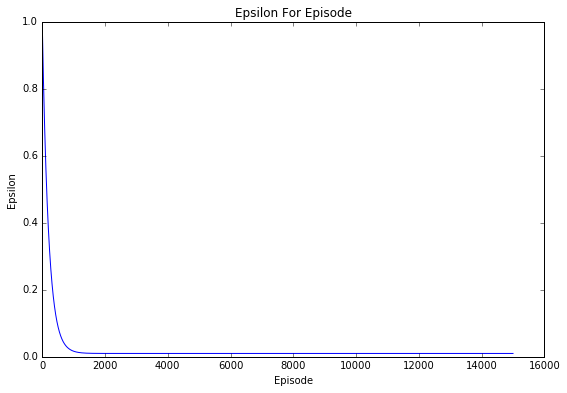

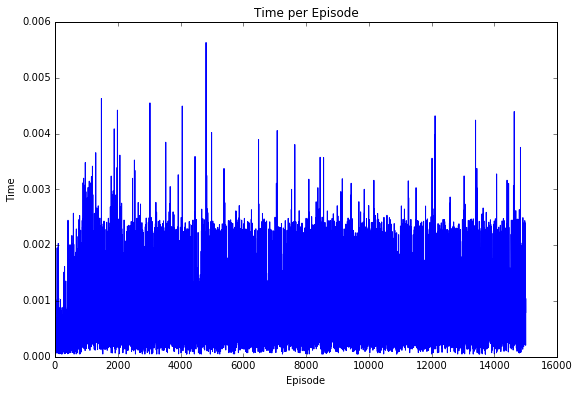

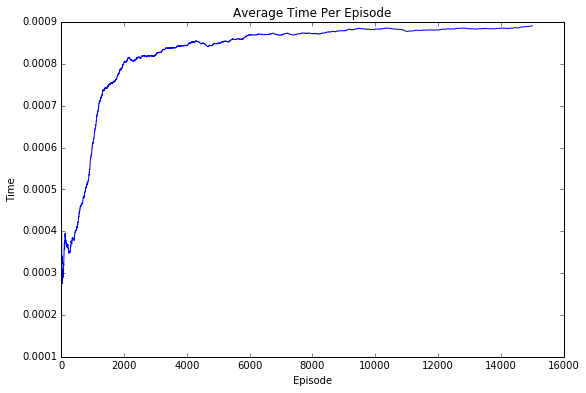

Score over time: 0.47613333333333335
Total time for Q-Learning =  13.536407947540283


In [253]:
run_Qlearning("4x4")

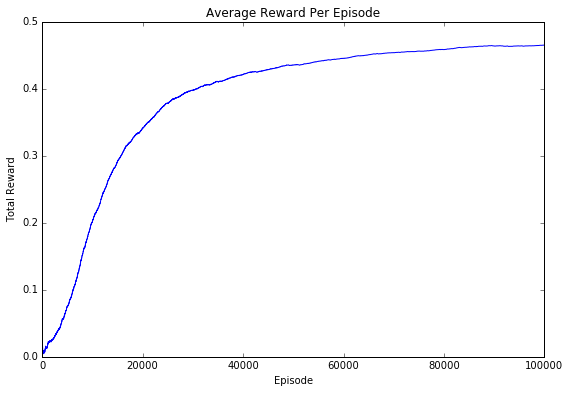

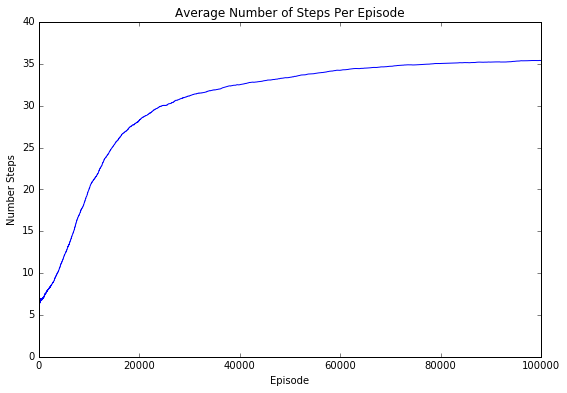

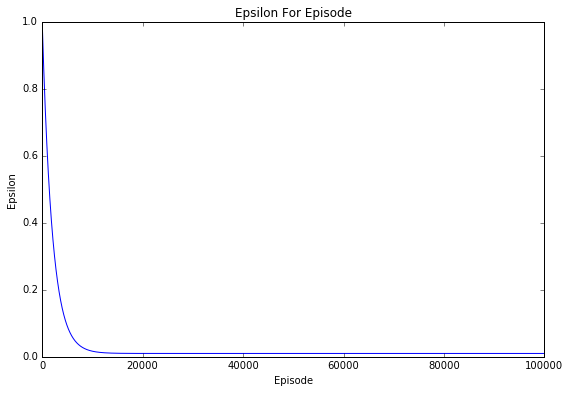

Score over time: 0.46514
[[8.65192075e-02 7.44585929e-03 7.95783748e-02 1.01474704e-02]
 [1.34399723e-03 3.24793074e-03 2.59801715e-03 3.37993946e-02]
 [2.33561559e-03 3.99786466e-03 1.53304596e-03 1.70237301e-02]
 [3.61059683e-05 1.18939991e-04 2.51582376e-03 1.02646145e-02]
 [3.94611421e-02 3.11419597e-03 1.81631848e-02 4.28451475e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.05296608e-03 9.07605470e-12 1.81296099e-03 2.56076388e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.32854988e-03 9.32548451e-04 7.67712858e-03 2.98434153e-02]
 [2.02620199e-03 2.99985972e-01 3.23923936e-03 5.03368479e-03]
 [2.12531249e-03 7.79665356e-02 1.62532950e-03 1.22699670e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.23660415e-02 1.36813332e-02 4.71009028e-01 3.15711143e-02]
 [4.87283451e-02 8.98256151e-01 2.71901769e-02 1.56201296e-01]
 [0.00000000e+00 0.00000000e+0

In [243]:
run_Qlearning("4x4", total_episodes=100000, decay_rate=0.0005)

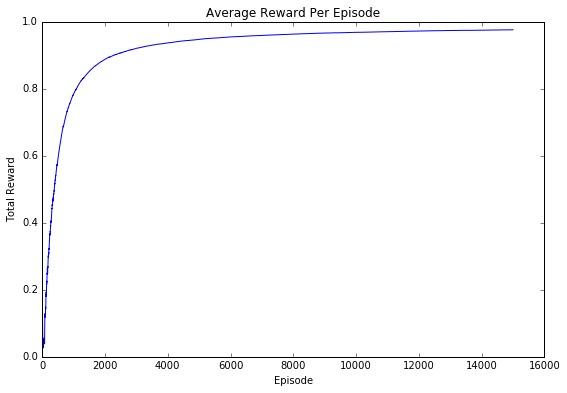

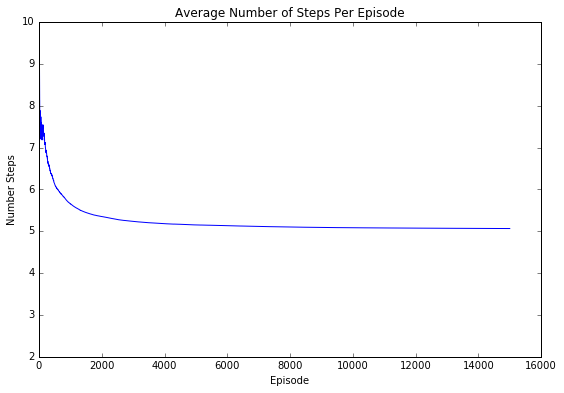

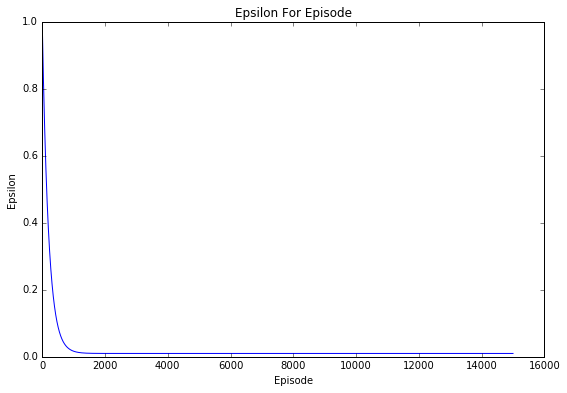

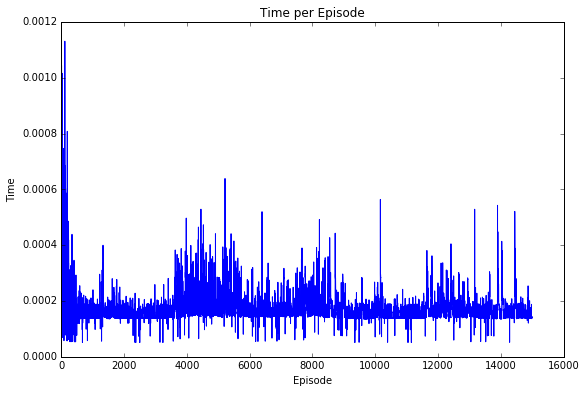

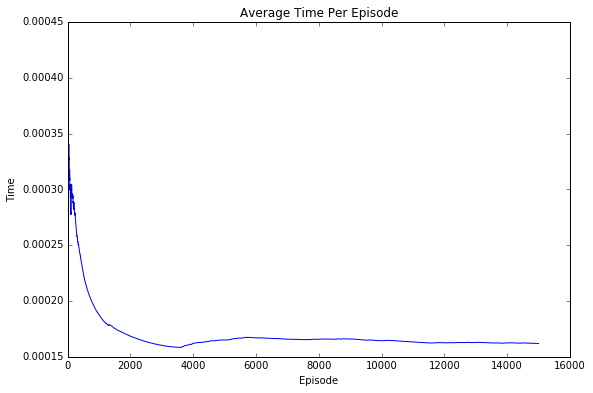

Score over time: 0.9767333333333333
Total time for Q-Learning =  2.610257863998413


In [256]:
run_Qlearning("4x4", stochastic=False)

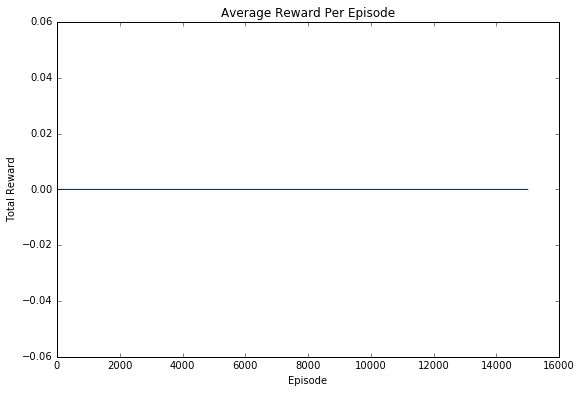

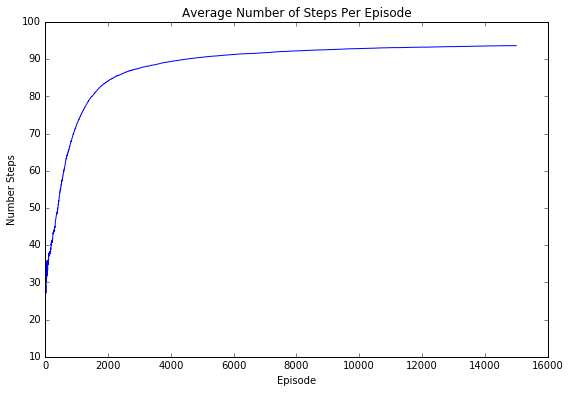

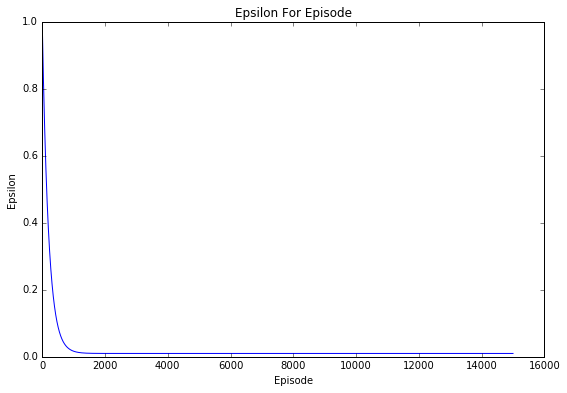

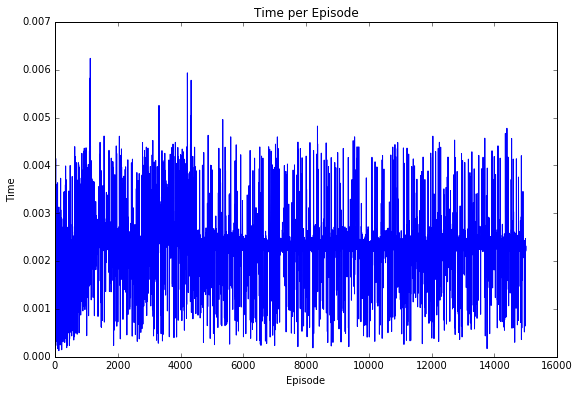

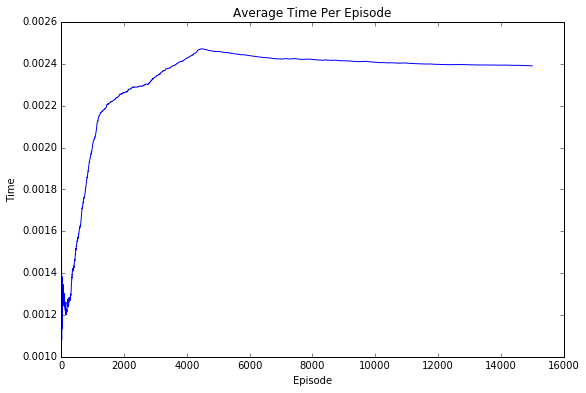

Score over time: 0.0
Total time for Q-Learning =  36.04928493499756


In [257]:
run_Qlearning("8x8")

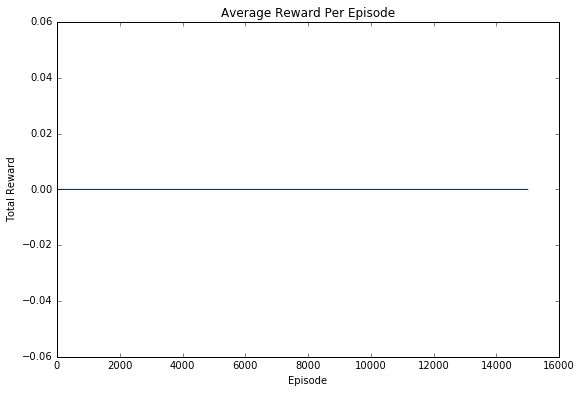

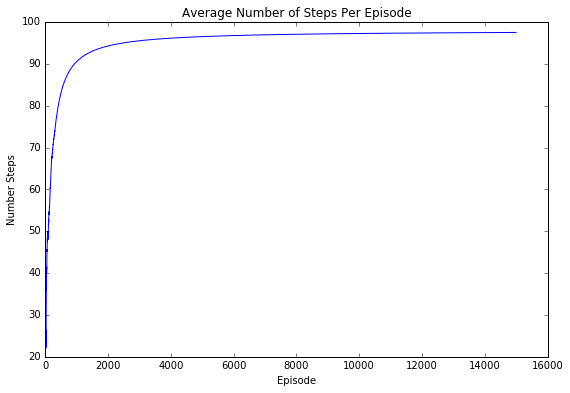

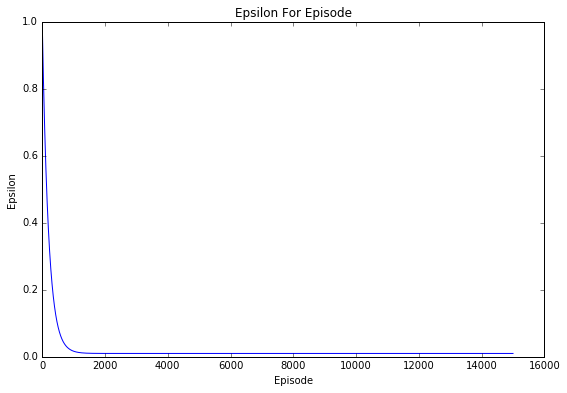

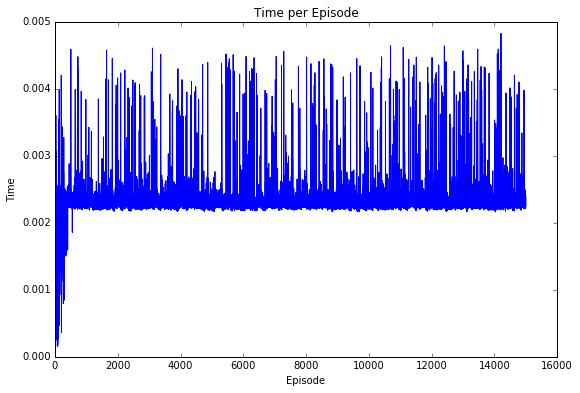

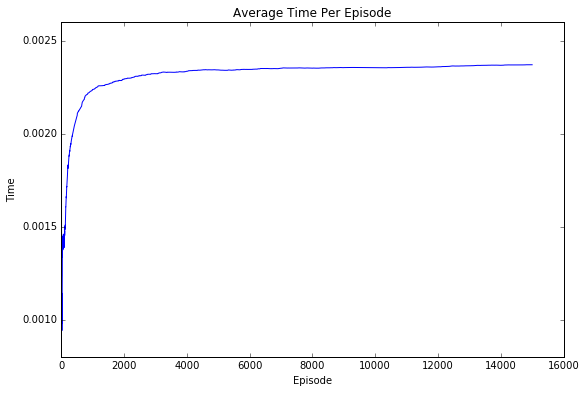

Score over time: 0.0
Total time for Q-Learning =  35.731959104537964


In [258]:
run_Qlearning("8x8", stochastic=False)

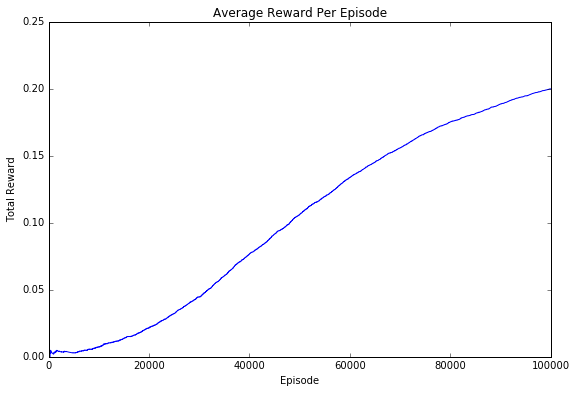

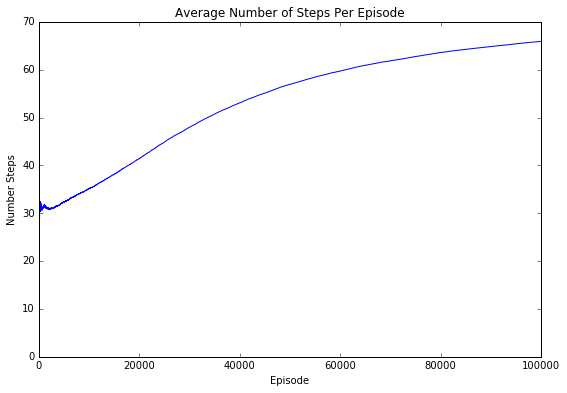

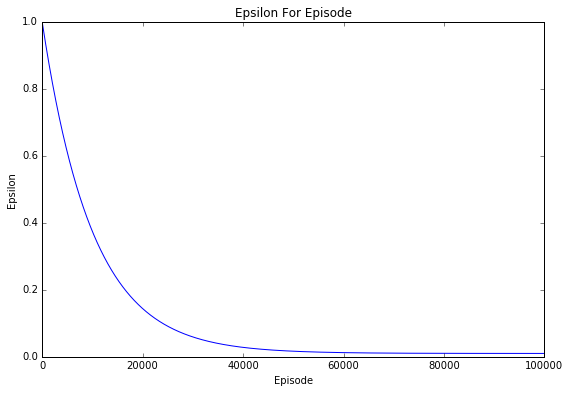

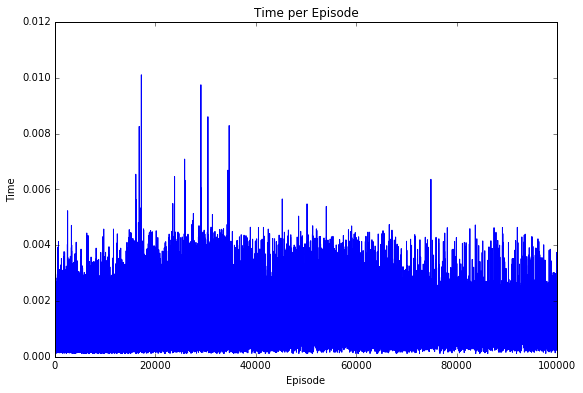

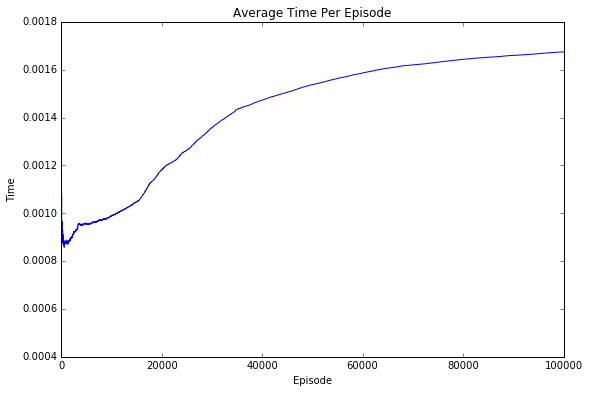

Score over time: 0.20006
Total time for Q-Learning =  168.76069498062134


In [259]:
run_Qlearning("8x8", total_episodes=100000, decay_rate=0.0001)

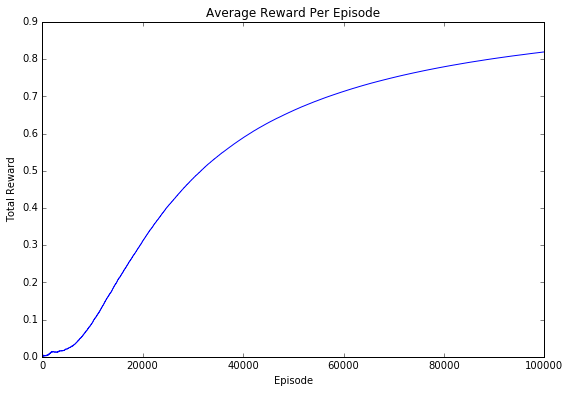

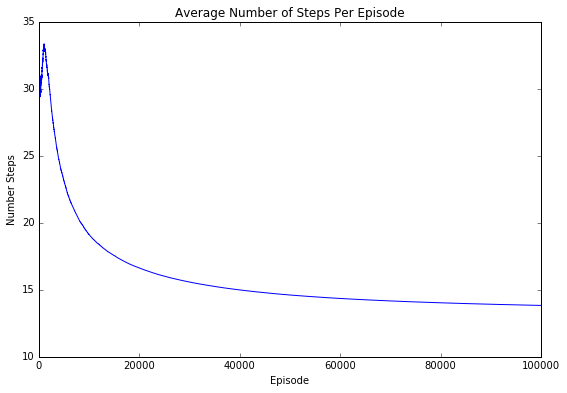

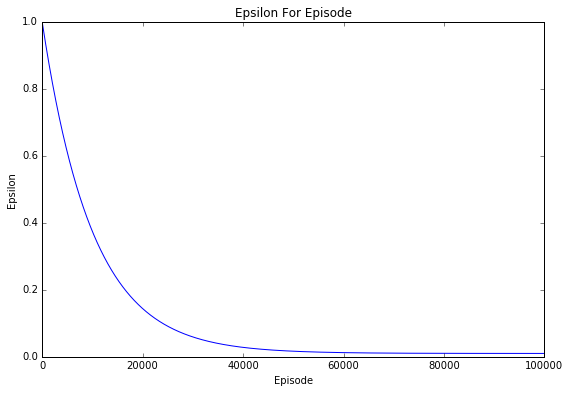

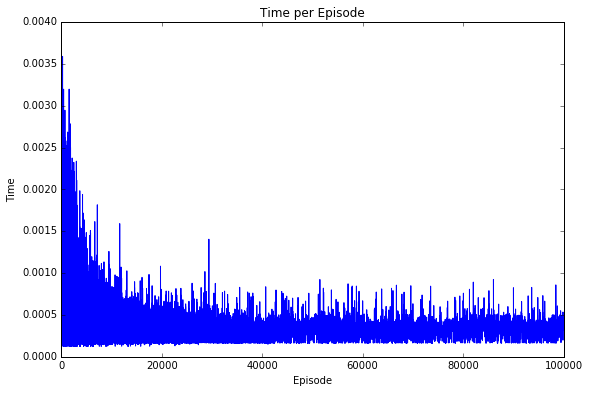

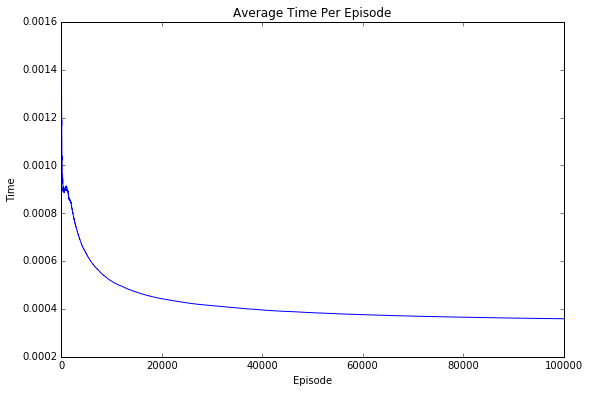

Score over time: 0.81966
Total time for Q-Learning =  37.04489016532898


In [260]:
run_Qlearning("8x8", total_episodes=100000, decay_rate=0.0001, stochastic=False)